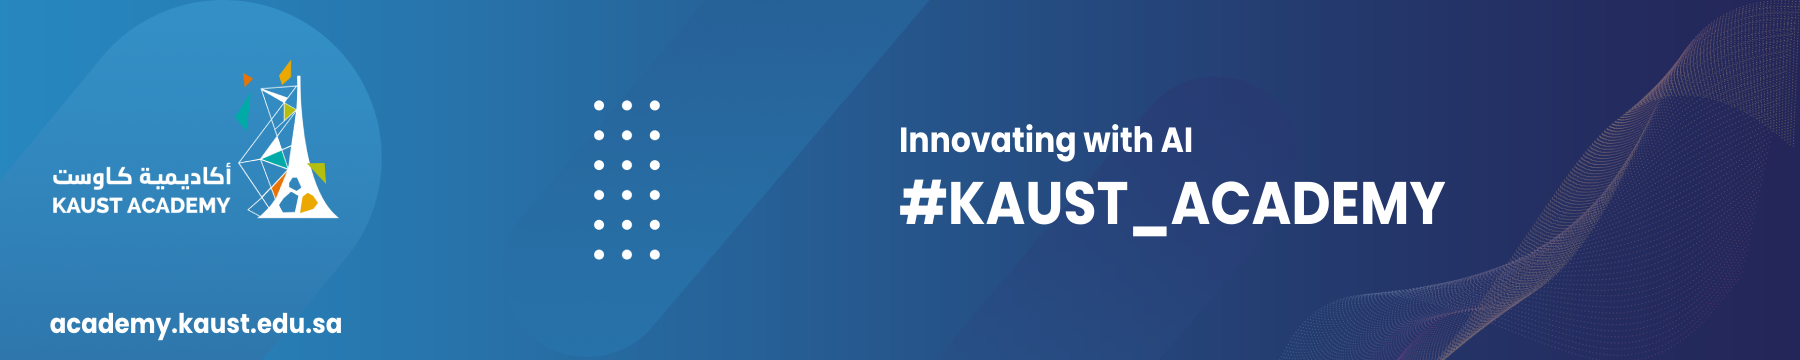

In [5]:
from IPython.display import clear_output

## Set up a virtual display

Mujoco rendering requires a display(even if we want to just generate rgb_array frames). A colab notebook does not have a display. Therefore we need to account for that by creating a virtual display

In [1]:
# needed to avoid glfw error
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [2]:
%%capture
!apt install -y python3-opengl
!apt install -y ffmpeg #Used to record and save videos
!apt install -y xvfb #X virtual framebuffer
!pip3 install pyvirtualdisplay

# clear_output()

In [3]:
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

In [6]:
%pip install gymnasium[mujoco] stable-baselines3
clear_output()

In [7]:
%pip install "gymnasium[mujoco]"
clear_output()

In [8]:
%pip install -U stable-baselines3[extra]
clear_output()

In [ ]:
# %pip install numpy matplotlib

# Content

In this demo we will use the Soft Actor Critic algorithm to solve the **"Humanoid Standup"** Environment. We will use Stable baselines3's implementation of SAC.

In the humanoid standup environment, a humanoid figure who is lying on the ground needs to get up and the actions are how much force to apply on humanoid's rotors and hunges. More info can be found [here](https://gymnasium.farama.org/environments/mujoco/humanoid_standup/)

![Pusher Image](https://gymnasium.farama.org/_images/humanoid_standup.gif)

In [9]:
import numpy as np

import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import NormalActionNoise
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [10]:
def frames_to_video(frames, fps=24):
    fig = plt.figure(figsize=(frames[0].shape[1] / 100, frames[0].shape[0] / 100), dpi=100)
    ax = plt.axes()
    ax.set_axis_off()

    if len(frames[0].shape) == 2:  # Grayscale image
        im = ax.imshow(frames[0], cmap='gray')
    else:  # Color image
        im = ax.imshow(frames[0])

    def init():
        if len(frames[0].shape) == 2:
            im.set_data(frames[0], cmap='gray')
        else:
            im.set_data(frames[0])
        return im,

    def update(frame):
        if len(frames[frame].shape) == 2:
            im.set_data(frames[frame], cmap='gray')
        else:
            im.set_data(frames[frame])
        return im,

    interval = 1000 / fps
    anim = FuncAnimation(fig, update, frames=len(frames), init_func=init, blit=True, interval=interval)
    plt.close()
    return HTML(anim.to_html5_video())

## Creating the environment

SB3 vectorized environments for multiple environments and faster training

In [11]:
# Create the environment

make_env = lambda: gym.make('HumanoidStandup-v5')
env = DummyVecEnv([make_env for _ in range(4)])  # adjust accoring to available ram
num_actions = env.action_space.shape[0]

In [12]:
noise_mean = np.array([0.0] * num_actions)
noise_std = np.array([0.1] * num_actions)

## Training the model

In [13]:
model = SAC("MlpPolicy",
            env,
            verbose=1,
            action_noise=NormalActionNoise(noise_mean, noise_std),  # noise for exploration
            learning_rate=1e-3)

Using cuda device


In [14]:
clear_output()
model.learn(total_timesteps=int(1e6), progress_bar=True)

Output()

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 214      |
|    time_elapsed    | 18       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -187     |
|    critic_loss     | 39.3     |
|    ent_coef        | 0.389    |
|    ent_coef_loss   | -23.3    |
|    learning_rate   | 0.001    |
|    n_updates       | 974      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 203      |
|    time_elapsed    | 39       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -364     |
|    critic_loss     | 77.3     |
|    ent_coef        | 0.186    |
|    ent_coef_loss   | -13.7    |
|    learning_rate   | 0.001    |
|    n_updates       | 1974     |
---------------------------------
---------------------------------
| time/       

## Evaluating and visualizing the performance of trained model

In [15]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f}")

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 155149.22


In [16]:
t_env = DummyVecEnv([lambda: gym.make('HumanoidStandup-v5', render_mode="rgb_array")])
state = t_env.reset()
frames = []

while True:
    action, _ = model.predict(state)
    state_next, r, done, info = t_env.step(action)
    frames.append(t_env.render())
    state = state_next
    if done.all():
        break

t_env.close()

In [ ]:
frames_to_video(frames)